In [25]:
import numpy as np
import pandas as pd
from random import sample
from matplotlib import pyplot as plt


file_name = 'BankProblem.txt'

''' This will read the data from the file name specifed and returns the data 
in pandas dataframe, capacity
'''
def getData(file_name):
    global total_possible_bags
    df = pd.DataFrame(columns=['weight','value'])
    capacity = 0
    f= open(file_name,"r")
    if f.mode == 'r':
        fl =f.readlines()
        capacity = int(fl[0].split(":")[1].strip())
        count=1
        for i in range(1,len(fl),3):
            weight = float(fl[i+1].replace('weight: ','').strip())
            value = float(fl[i+2].replace('value: ','').strip())        
            df = df.append(pd.Series({'weight':weight,'value':value},name=count))
            count = count + 1
        total_possible_bags = count-1;
    f.close()
    return df,capacity

'''
Generate Random population from the 

'''
def generate_random_pp(population_size=10): 
    #Lets say we choose bags from 45 - 55 out of 100
    global num_bags_choosen
    num_bags_choosen = np.random.randint(45,55)    
    
    global generated_population 
    generated_population = pd.DataFrame(columns=['S','F(S)'])
    
    #Generate random solution for above specified population size
    for i in range(population_size) :
        S = sorted(sample(range(1,total_possible_bags+1),k=num_bags_choosen))
        FS = fitness_func(S)
        generated_population = generated_population.append({'S':S,'F(S)':FS},ignore_index=True)
    generated_population.sort_values('F(S)',ascending=True,inplace=True)
    return generated_population

'''
Fitness function  : if the bags more than capacity then fitness_fun will give 0 
else it gives the fraction of sample weight to total weight
'''
def fitness_func(bags):
    if data.loc[bags,'weight'].sum() <= capacity and isFeasible(bags):
        return data.loc[bags,'value'].sum()/data['value'].sum()
    else:
        return 0 

'''
Duplicate bags check 
'''
def isFeasible(C):
    if len(C) == len(set(C)):
        return True
    else:
        return False
    
'''
Selects the tournments and samples from the population for crossover and mutation purpose
'''
def tournmentSelection(t=2):
    #Select the random populations by using tournment size and return one of the best of these t induviduals selected
    selectedTournment = generated_population.iloc[sample(range(population_size),k=t)]
    return selectedTournment[selectedTournment["F(S)"] == selectedTournment["F(S)"].max()]  
    
'''
Single point crossover to generate C, D from the tournement generated data
'''
def singlePointCrossover(tournmentData):
    crossOverPoint  = np.random.randint(1,num_bags_choosen+1)
    A = tournmentData.iloc[0].S.copy()
    B = tournmentData.iloc[1].S.copy()
    C = A[:crossOverPoint] + B[crossOverPoint:]
    D = B[:crossOverPoint] + A[crossOverPoint:] 
    return sorted(C),sorted(D)

'''
Mutate based on the number of mutation provided m
output will be E, F, F(E), F(F)
Still not complete
'''
def mutation(C,D,m=1):
    #Choose the 
    mutationIndex  = sample(range(1,num_bags_choosen),k=m)
    E = C.copy()
    F = D.copy()
    SE = sample(range(1,num_bags_choosen),k=m)
    SF = sample(range(1,num_bags_choosen),k=m) 
    count=0
    for i in mutationIndex :
        E[i] = SE[count]
        F[i] = SF[count]
        count = count+1
    return sorted(E),sorted(F),fitness_func(E),fitness_func(F)

'''
Weekest Replacement logic with Mutated Childs E, F
'''
def weekest_replacement(E,F,FE,FF):
    index = 0
    if generated_population.iloc[index]['F(S)'] < FE and not isDuplicateSolution(E):
        generated_population.iloc[index]=[E,FE]
        index += 1
    if generated_population.iloc[index]['F(S)'] < FF and not isDuplicateSolution(F):
        generated_population.iloc[index]=[F,FF]
    generated_population.sort_values('F(S)',ascending=True,inplace=True)
    
def isDuplicateSolution(S):
    for val in generated_population.loc[:,'S']:
        if(val==S):
            return True
    return False

def plot_data(op,title):
    x = op.index.tolist()
    fig, (ax1, ax2) = plt.subplots(2,sharex=True)
    fig.suptitle(title)
    ax1.plot(x,op.iloc[:,1],label="Cumilative Value",color='red')
    ax2.plot(x,op.iloc[:,2]*100,label="Fitness",color='green')
    ax1.set_xticks([0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000])
    ax2.set_xticks([0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000])
    plt.show()

'''
Run Evolutionary Algorithm
pass number of iterations to run
'''
def run(num_runs=10000,t=2,m=10,pop_size=20):
    global data,capacity,population_size
    population_size=pop_size
    data,capacity = getData(file_name)
    generate_random_pp(population_size)
    (cum_weight,cum_value) = data.loc[generated_population.iloc[-1,0]].sum()
    iteration_result= pd.DataFrame(columns=['Cumilative weight','Cumilative Value','F(S)'])
    #print(generated_population)
    iteration_result = iteration_result.append(pd.Series({'Cumilative weight':cum_weight,'Cumilative Value':cum_value,'F(S)':generated_population.iloc[-1,1]},name='0'))
    for i in range(1,num_runs+1):
        tournmentSelected = tournmentSelection(t=t)
        tournmentSelected = tournmentSelected.append(tournmentSelection(t=t))
        C,D = singlePointCrossover(tournmentSelected)
        E,F,FE,FF = mutation(C,D,m=m)
        total_replacements = weekest_replacement(E,F,FE,FF)
        (cum_weight,cum_value) = data.loc[generated_population.iloc[-1,0]].sum()
        iteration_result = iteration_result.append(pd.Series({'Cumilative weight':cum_weight,'Cumilative Value':cum_value,'F(S)':generated_population.iloc[-1,1]},name=i))
    return generated_population,iteration_result 


In [ ]:
'''

Impact of population size on result
popSize=10,20,50,100,200

'''

popSize=[10,20,50,100,200]

popSizeResults = pd.DataFrame(columns=['weight','value'])
indexes = []

for size in popSize:
    generated_population,iteration_result = run(num_runs=10000,m=2,t=2,pop_size=size)
    popSizeResults = popSizeResults.append(data.loc[generated_population.iloc[-1,0]].sum(),ignore_index=True)
    indexes.append("num_runs=10000,m=2,t=2,pop_size="+str(size))
    plot_data(iteration_result,title="num_runs=10000,m=2,t=2,pop_size="+str(size))
popSizeResults.index = indexes
popSizeResults

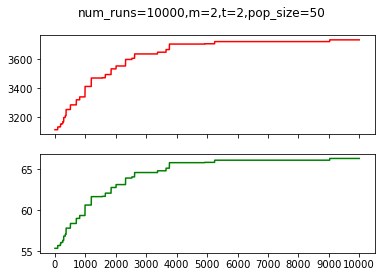

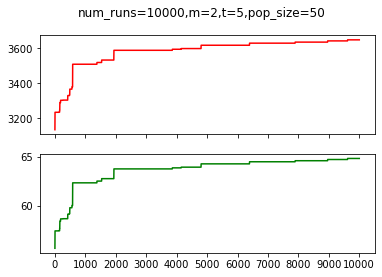

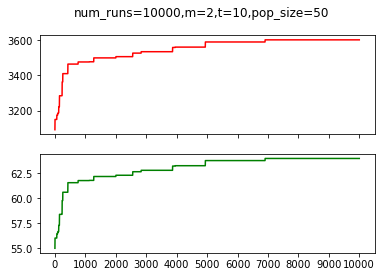

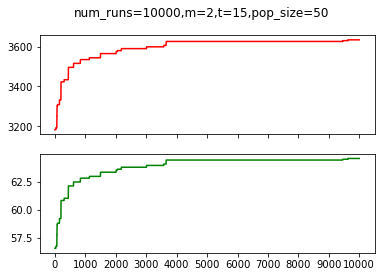

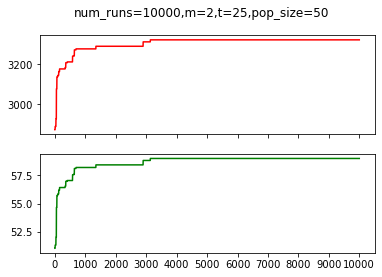

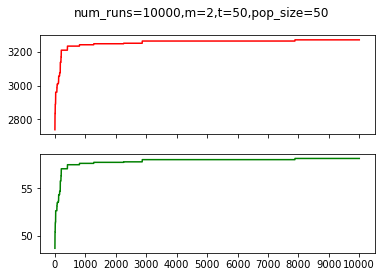

,weight,value
"num_runs=10000,m=2,t=2,pop_size=50",263.5,3734.0
"num_runs=10000,m=2,t=5,pop_size=50",271.2,3649.0
"num_runs=10000,m=2,t=10,pop_size=50",275.5,3601.0
"num_runs=10000,m=2,t=15,pop_size=50",270.6,3634.0
"num_runs=10000,m=2,t=25,pop_size=50",271.4,3320.0
"num_runs=10000,m=2,t=50,pop_size=50",262.9,3270.0


In [18]:
'''

Impact of Tournment size on result
tournmentSize=2,5,10,15,25,50
popSize=50

'''
tournmentSize=[2,5,10,15,25,50]

tournmentSizeResults = pd.DataFrame(columns=['weight','value'])
indexes = []
for size in tournmentSize:
    generated_population,iteration_result = run(num_runs=10000,m=2,t=size,pop_size=50)
    tournmentSizeResults = tournmentSizeResults.append(data.loc[generated_population.iloc[-1,0]].sum(),ignore_index=True)
    indexes.append("num_runs=10000,m=2,t="+str(size)+",pop_size=50")
    plot_data(iteration_result,title="num_runs=10000,m=2,t="+str(size)+",pop_size=50")
tournmentSizeResults.index = indexes
tournmentSizeResults

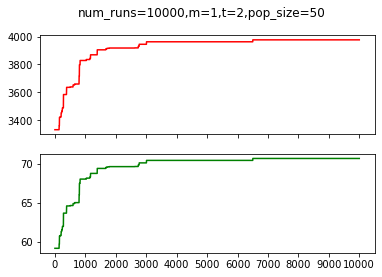

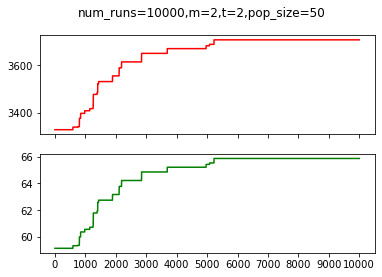

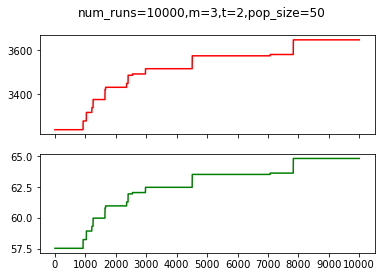

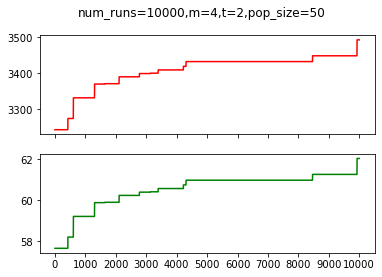

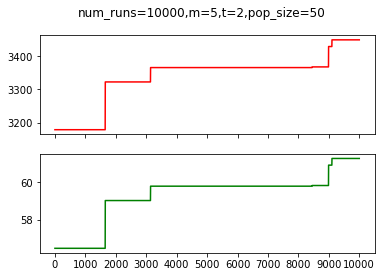

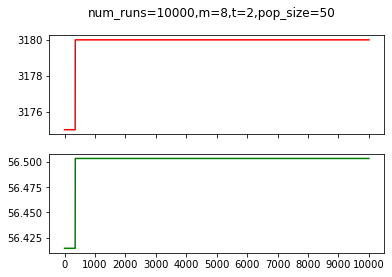

,weight,value
"num_runs=10000,m=1,t=2,pop_size=50",276.6,3978.0
"num_runs=10000,m=2,t=2,pop_size=50",269.4,3707.0
"num_runs=10000,m=3,t=2,pop_size=50",269.1,3648.0
"num_runs=10000,m=4,t=2,pop_size=50",267.3,3492.0
"num_runs=10000,m=5,t=2,pop_size=50",268.6,3448.0
"num_runs=10000,m=8,t=2,pop_size=50",272.2,3180.0


In [19]:
'''

Impact of Mutation on result
mutation=1,2,5,10,15,25
tourmentSize=2
popSize=50
mutation=[1,2,3,4,5,8]

'''
mutationObj=[1,2,3,4,5,8]

mutationResults = pd.DataFrame(columns=['weight','value'])
indexes = []
for size in mutationObj:
    generated_population,iteration_result = run(num_runs=10000,m=size,t=2,pop_size=50)
    mutationResults = mutationResults.append(data.loc[generated_population.iloc[-1,0]].sum(),ignore_index=True)
    indexes.append("num_runs=10000,m="+str(size)+",t=2,pop_size=50")
    plot_data(iteration_result,title="num_runs=10000,m="+str(size)+",t=2,pop_size=50")
mutationResults.index = indexes
mutationResults